# Hartree-Fock 交换算符

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bud-primordium/AtomSCF/blob/main/docs/source/tutorials/04-hartree-fock.ipynb)

## 学习目标

- 理解 Hartree-Fock 方法的交换积分
- 掌握 Slater 径向积分的物理意义
- 对比 HF 交换与 DFT 交换的核心差异

## HF 交换的物理图像

Hartree-Fock 方法通过反对称化波函数自然引入交换项：

$$\hat{K}[u_i](r) = -\sum_{j \text{ occ}} \int_0^\infty \frac{u_j(r) u_j(r') u_i(r')}{|r - r'|} dr'$$

对球对称原子，交换算符通过 Slater 径向积分实现：

$$R^k_{ij}(r) = \int_0^\infty \frac{r_<^k}{r_>^{k+1}} u_i(r') u_j(r') dr'$$

角动量选择规则限制 $k$ 的取值：$|l_i - l_j| \leq k \leq l_i + l_j$，且 $k$ 与 $l_i + l_j$ 同奇偶。

## 理论基础：Hartree-Fock 交换

Hartree-Fock 方法显式处理交换积分（反对称性）。

### Fock 算符

$$\hat{F} = \hat{h} + \hat{J} - \hat{K}$$

其中：
- $\hat{h}$：单电子 Hamiltonian（动能 + 核势）
- $\hat{J}$：Coulomb 算符（Hartree 势）
- $\hat{K}$：交换算符

### 交换势（Slater 积分）

对于原子轨道 $\psi_i = u_i(r)Y_{lm}$，交换算符矩阵元：

$$K_{ij} = \sum_k f_k \int\int \frac{\psi_i^*(r)\psi_k^*(r')\psi_k(r')\psi_j(r)}{|r-r'|}d^3r d^3r'$$

球对称简化为 Slater 积分：

$$R^k(r) = \int_0^\infty \frac{r_<^k}{r_>^{k+1}}|u_j(r')|^2 dr'$$

**代码实现**：`exchange_operator_general()` 构造交换矩阵


In [1]:
# 环境配置
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/bud-primordium/AtomSCF.git

In [2]:
# 配置中文字体（避免乱码）
import matplotlib.pyplot as plt
import matplotlib

# 跨平台中文字体配置
matplotlib.rcParams['font.sans-serif'] = [
    'Arial Unicode MS',      # macOS
    'WenQuanYi Micro Hei',  # Linux
    'SimHei',                # Windows
    'DejaVu Sans'            # Fallback
]
matplotlib.rcParams['axes.unicode_minus'] = False

# 清除字体缓存（重要！）
try:
    import matplotlib.font_manager as fm
    fm._load_fontmanager(try_read_cache=False)
except Exception:
    pass


In [3]:

import numpy as np
import matplotlib.pyplot as plt
from atomscf.grid import radial_grid_linear
from atomscf.scf_hf import HFSCFGeneralConfig, run_hf_scf
from atomscf.hf.slater import slater_integral_radial

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 5)


def get_hf_energy(result):
    return getattr(result, 'E_total', 0.0)


def get_hf_eps(result, l, idx=0):
    values = result.eigenvalues_by_l.get(l)
    if values is None or idx >= len(values):
        return 0.0
    return float(values[idx])



## He 原子 HF 计算

氦（Z=2）闭壳层 1s²，是最简单的多电子体系：

In [4]:

# 生成网格
r, w = radial_grid_linear(n=1000, rmin=1e-5, rmax=30.0)

# 配置 He 原子 HF（Z=2 会自动使用 RHF，1s²）
cfg_he = HFSCFGeneralConfig(
    Z=2,
    r=r,
    w=w,
    occ_by_l={0: [2.0]},  # He: 1s^2
    eigs_per_l={0: 1},    # 只需求解 1 个 s 态
    maxiter=50,
    tol=1e-6,  # 参数名是 tol 而不是 conv_tol
)

# 运行 HF 自洽
result_he = run_hf_scf(cfg_he)

hf_total = get_hf_energy(result_he)
hf_eps_1s = get_hf_eps(result_he, l=0, idx=0)

print('He 原子 HF 结果:')
print(f'  收敛: {result_he.converged}')
print(f'  迭代次数: {result_he.iterations}')
print(f'  总能量: {hf_total:.6f} Hartree')
print(f'  总能量: {hf_total * 27.211:.3f} eV')
print(f'  1s 轨道能量: {hf_eps_1s:.6f} Hartree')



## Slater 积分可视化

对 He 的 1s 轨道，计算 Slater 径向积分 $R^0_{1s,1s}(r)$：

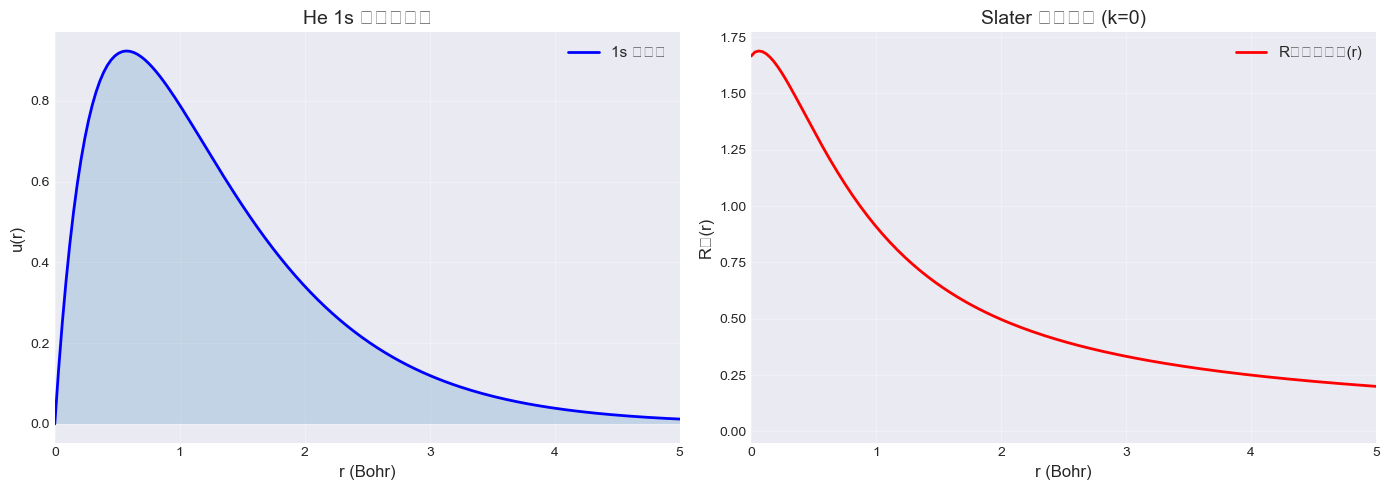

In [5]:
# 提取 1s 波函数
u_1s = result_he.orbitals_by_l[0][0]

# 计算 R^0 Slater 积分
R0_1s1s = slater_integral_radial(r, w, u_1s, u_1s, k=0)

# 可视化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 左图：波函数
ax1.plot(r, u_1s, 'b-', linewidth=2, label='1s 波函数')
ax1.fill_between(r, 0, u_1s, alpha=0.2)
ax1.set_xlabel('r (Bohr)', fontsize=12)
ax1.set_ylabel('u(r)', fontsize=12)
ax1.set_title('He 1s 轨道波函数', fontsize=14)
ax1.set_xlim(0, 5)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# 右图：Slater 积分
ax2.plot(r, R0_1s1s, 'r-', linewidth=2, label='R⁰₁ₛ₁ₛ(r)')
ax2.set_xlabel('r (Bohr)', fontsize=12)
ax2.set_ylabel('R⁰(r)', fontsize=12)
ax2.set_title('Slater 径向积分 (k=0)', fontsize=14)
ax2.set_xlim(0, 5)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nR⁰ 积分在 r=0 处的值: {R0_1s1s[0]:.6f}")
print(f"R⁰ 积分在 r→∞ 处的渐近值: {R0_1s1s[-100]:.6f}")

## HF vs DFT 比较

对比 He 原子的 HF 和 LDA 结果：

In [6]:

from atomscf.scf import SCFConfig, run_lsda_pz81

# He 原子 LDA 计算（Z=2 会自动使用 default_occupations）
cfg_lda = SCFConfig(
    Z=2,
    r=r,
    w=w,
    maxiter=50,
    tol=1e-6,
)

result_lda = run_lsda_pz81(cfg_lda)

hf_total = get_hf_energy(result_he)
hf_eps_1s = get_hf_eps(result_he, l=0, idx=0)
lsda_total = result_lda.energies.get('E_total', 0.0) if result_lda.energies else 0.0
lsda_1s_energy = result_lda.eps_by_l_sigma.get((0, 'up'), [0.0])[0]

print('方法比较 (He 原子):')
print('\n  方法         总能量 (Ha)   1s 能量 (Ha)')
print('  ' + '-' * 48)
print(f'  HF          {hf_total:>12.6f}  {hf_eps_1s:>12.6f}')
print(f'  LSDA-PZ81   {lsda_total:>12.6f}  {lsda_1s_energy:>12.6f}')

delta = abs(hf_total - lsda_total)
print(f'\n  能量差: {delta:.6f} Ha')
print(f'  能量差: {delta * 27.211:.3f} eV')



## 核心差异

| 特性 | Hartree-Fock | DFT-LDA |
|------|--------------|----------|
| 交换处理 | 非局域（Slater 积分） | 局域近似（Dirac 泛函） |
| 计算复杂度 | O(N⁴) | O(N²) |
| 自洽难度 | 较高（交换矩阵构造） | 较低（密度泛函） |
| 物理图像 | 波函数反对称化 | 均匀电子气模型 |

**关键洞察**：
- HF 交换是精确的，但不包含关联
- LDA 同时近似交换和关联，误差相互抵消
- 对小原子，HF 通常更接近实验能量

## 下一步

在 **[05-dft-xc.ipynb](05-dft-xc.ipynb)** 中，深入理解 DFT 的交换关联泛函实现细节。